In [1]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# # Read sqlite query results into a pandas DataFrame
# con = sqlite3.connect("../Data/citibike.sqlite")
# df = pd.read_sql_query("SELECT * FROM allrides where date(starttime)==strftime("2019-07-01"), con)

# # Verify that result of SQL query is stored in the dataframe
# print(df.head())

# con.close()

In [16]:
sample = pd.read_csv('../Data/allrides_sample2.csv')
stations = pd.read_csv('../Data/live_stations.csv') # all stations after '2019-12-01'
print(f'sample size: {sample.shape}')
print(f'sample columns: {sample.columns}')

sample size: (2000000, 15)
sample columns: Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')


#### <i>problem 1: start station id has non-unqiue names and lat & long information

In [17]:
print(stations.shape)
print(stations['station_id'].unique().size)
print(stations['station_name'].unique().size)
print(stations['station_lat'].unique().size)
print(stations['station_long'].unique().size)

(1001, 4)
895
897
927
922


In [74]:
stations.head(8)

,station_id,station_name,station_lat,station_long
0,3382,Carroll St & Smith St,40.680611,-73.994758
1,362,Broadway & W 37 St,40.751726,-73.987535
2,146,Hudson St & Reade St,40.716250,-74.009106
3,3834,Irving Ave & Halsey St,40.694670,-73.906630
4,500,Broadway & W 51 St,40.762288,-73.983362
5,340,Madison St & Clinton St,40.712690,-73.987763
6,469,Broadway & W 53 St,40.763441,-73.982681
7,448,W 37 St & 10 Ave,40.756604,-73.997901


In [101]:
# Test
# station_dict={}
# for station in [3382,362,146,3834,500,340,469,448]:
#     loc1=(stations[stations.station_id==station].station_lat.values,stations[stations.station_id==station].station_long.values)
#     others=[x for x in [3382,362,146,3834,500,340,469,448] if x != station]
#     dist_to_others={}
#     for othr_station in others:
#         loc2=(stations[stations.station_id==othr_station].station_lat.values,stations[stations.station_id==othr_station].station_long.values)
#         distance=(abs(loc1[0]-loc2[0])+abs(loc1[1]-loc2[1]))[0]
#         dist_to_others[othr_station]=distance
#     dist_to_others=sorted(dist_to_others.items(), key = lambda kv:(kv[1], kv[0])) # sort by smallest distance
#     station_dict[station]=dist_to_others

#station_dict

In [107]:
# Do Not run this cell - it will take over 30 minutes.
station_dict={}
for station in stations.station_id.unique().tolist():
    loc1=(stations[stations.station_id==station].station_lat.values,stations[stations.station_id==station].station_long.values)
    others=[x for x in stations.station_id.unique().tolist() if x != station]
    dist_to_others={}
    for othr_station in others:
        loc2=(stations[stations.station_id==othr_station].station_lat.values,stations[stations.station_id==othr_station].station_long.values)
        distance=(abs(loc1[0]-loc2[0])+abs(loc1[1]-loc2[1]))[0]
        dist_to_others[othr_station]=distance
    dist_to_others=sorted(dist_to_others.items(), key = lambda kv:(kv[1], kv[0])) # sort by smallest distance
    station_dict[station]=dist_to_others


In [108]:
# Do Not run this cell
# save station_dict as pickled object.
import pickle
output = open('station_dict.pkl', 'wb')
pickle.dump(station_dict, output, -1)
output.close()

In [111]:
# import station_dict
import pickle
station_dict = pickle.load(open("station_dict.pkl", "rb"))

### transform Dates

In [18]:
def reformat_date(df):
'''this function parses date, hour, min from the starttime and endtime
    creates "season" based on the month
    creates "dayofweek" and "year" from the date
    creates 30 minute intervals from the datetime columns specified in datecol in the function.'''
    datecol=['starttime','stoptime']
    for col in datecol:
        df[col]=pd.to_datetime(sample[col])
        hourcol=col+'_hour'
        mincol=col+'_min'
        datecol=col+'_date'
        df[datecol]=df[col].dt.date
        df[hourcol]=df[col].dt.hour
        df[mincol]=df[col].dt.minute
        df[mincol]=df[mincol].apply(lambda x: '00' if x < 30 else '30')
        df[col+'_interval']=df.apply(lambda x: str(x[hourcol])+":"+str(x[mincol]), axis=1)
    df['season']=df['starttime'].dt.month.apply(lambda x: 'winter' if x <=2 else 'spring' if x<=5 else 
                                              'summer' if x<=8 else 'fall' if x<=11 else 'winter')
    df['dayofweek']=df['starttime'].dt.weekday
    df['year']=df['starttime'].dt.year

In [19]:
reformat_date(sample)

In [20]:
sample.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'starttime_date', 'starttime_hour',
       'starttime_min', 'starttime_interval', 'stoptime_date', 'stoptime_hour',
       'stoptime_min', 'stoptime_interval', 'season', 'dayofweek', 'year'],
      dtype='object')

### Remove rides from or to old bike stations that no longer exist as of 2019-12-01.

In [30]:
sample_new=sample[sample['start station id'].isin(stations.station_id.unique().tolist())]
sample_new=sample_new[sample_new['end station id'].isin(stations.station_id.unique().tolist())]
sample_new=sample_new[sample_new['year']!=2020]
sample_new=sample_new[sample_new['starttime_hour']>=6]
sample_new.shape

(1588155, 26)

### Another issue: new stations that were built 2018/2019 doesn't have data for 2015,2016 etc.

In [31]:
temp=pd.DataFrame(sample_new.groupby('year')['start station id'].unique())
temp['count']=temp['start station id'].apply(lambda x: len(x))
temp

,start station id,count
year,,
2015,"[368.0, 526.0, 417.0, 446.0, 361.0, 377.0, 489...",398
2016,"[417.0, 3085.0, 261.0, 307.0, 3256.0, 268.0, 1...",541
2017,"[3348.0, 523.0, 442.0, 304.0, 3344.0, 340.0, 3...",691
2018,"[3177.0, 398.0, 3656.0, 267.0, 3686.0, 275.0, ...",721
2019,"[3314.0, 3056.0, 212.0, 3749.0, 514.0, 402.0, ...",877


## Visualizing Data

### Hourly distribution of rides seem to be very similar across years 2015-2019.
<i> this is great because rides do follow some sort of hourly trend.
- intuitivelly, the chart below makes sense in term of:
    - similar season trends. higher rides in summer and fall and low rides in spring and winter
    - more rides during weekday.
    - more rides during rush hour.

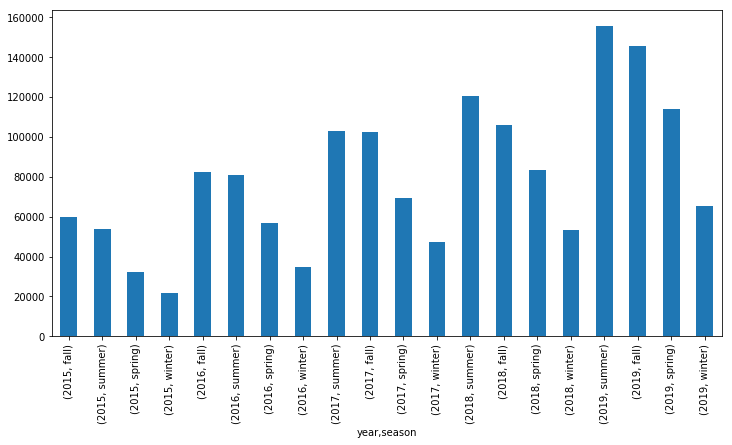

In [32]:
sample_new['season'] = pd.Categorical(sample_new['season'], ["spring", "summer", "fall","winter"])
plt.figure(figsize=(12,6))
sample_new.sort_values("season").groupby('year')['season'].value_counts().plot.bar()

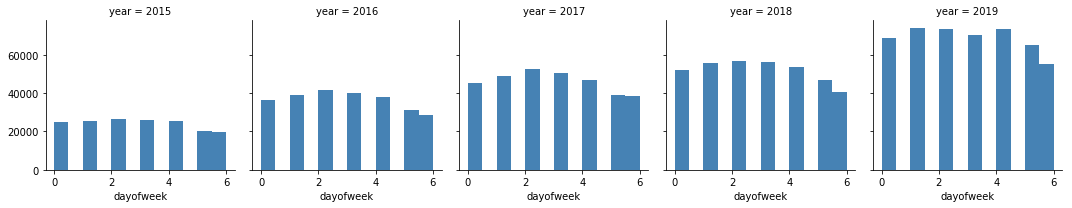

In [33]:
g=sns.FacetGrid(sample_new, col="year", margin_titles=True)
g.map(plt.hist, "dayofweek", color="steelblue", bins=12)

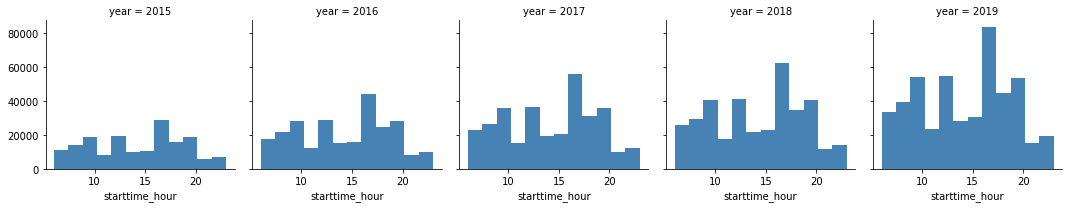

In [34]:
g=sns.FacetGrid(sample_new, col="year", margin_titles=True)
g.map(plt.hist, "starttime_hour", color="steelblue", bins=12)

### Feature Engineering

In [35]:
sample_new.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'starttime_date', 'starttime_hour',
       'starttime_min', 'starttime_interval', 'stoptime_date', 'stoptime_hour',
       'stoptime_min', 'stoptime_interval', 'season', 'dayofweek', 'year'],
      dtype='object')

### Construct a DataFrame for each Bike Station/Time Interval:
- Feature: Station_id | time_interval | season | dayofweek
- Target: bike_demand | dock_demand 

In [140]:
temp=sample_new.groupby(['start station id','starttime_date','starttime_interval'])[['starttime']].count().reset_index()
outgoingRides=pd.merge(temp,sample_new[['start station id','starttime_date','season','dayofweek']],on=['start station id','starttime_date'], how='left').rename(columns={"starttime": "outgoing_bike_count"})                                                                                                                
incomingRides=sample_new.groupby(['end station id','stoptime_date','stoptime_interval'])[['stoptime']].count().reset_index().rename(columns={'stoptime':'incoming_bike_count'})
temp=pd.merge(outgoingRides,incomingRides, left_on=['start station id','starttime_date','starttime_interval'],
        right_on = ['end station id','stoptime_date','stoptime_interval']).drop(columns=['end station id','stoptime_date','stoptime_interval']).\
rename(columns={'start station id':'station_id','starttime_date':'date','starttime_interval':'time_interval'})
df=temp.groupby(['station_id','time_interval','season','dayofweek']).sum()[['outgoing_bike_count','incoming_bike_count']].reset_index()

In [141]:
df.outgoing_bike_count.fillna(0, inplace=True)
df.incoming_bike_count.fillna(0, inplace=True)

### Visualizing Bike Demands

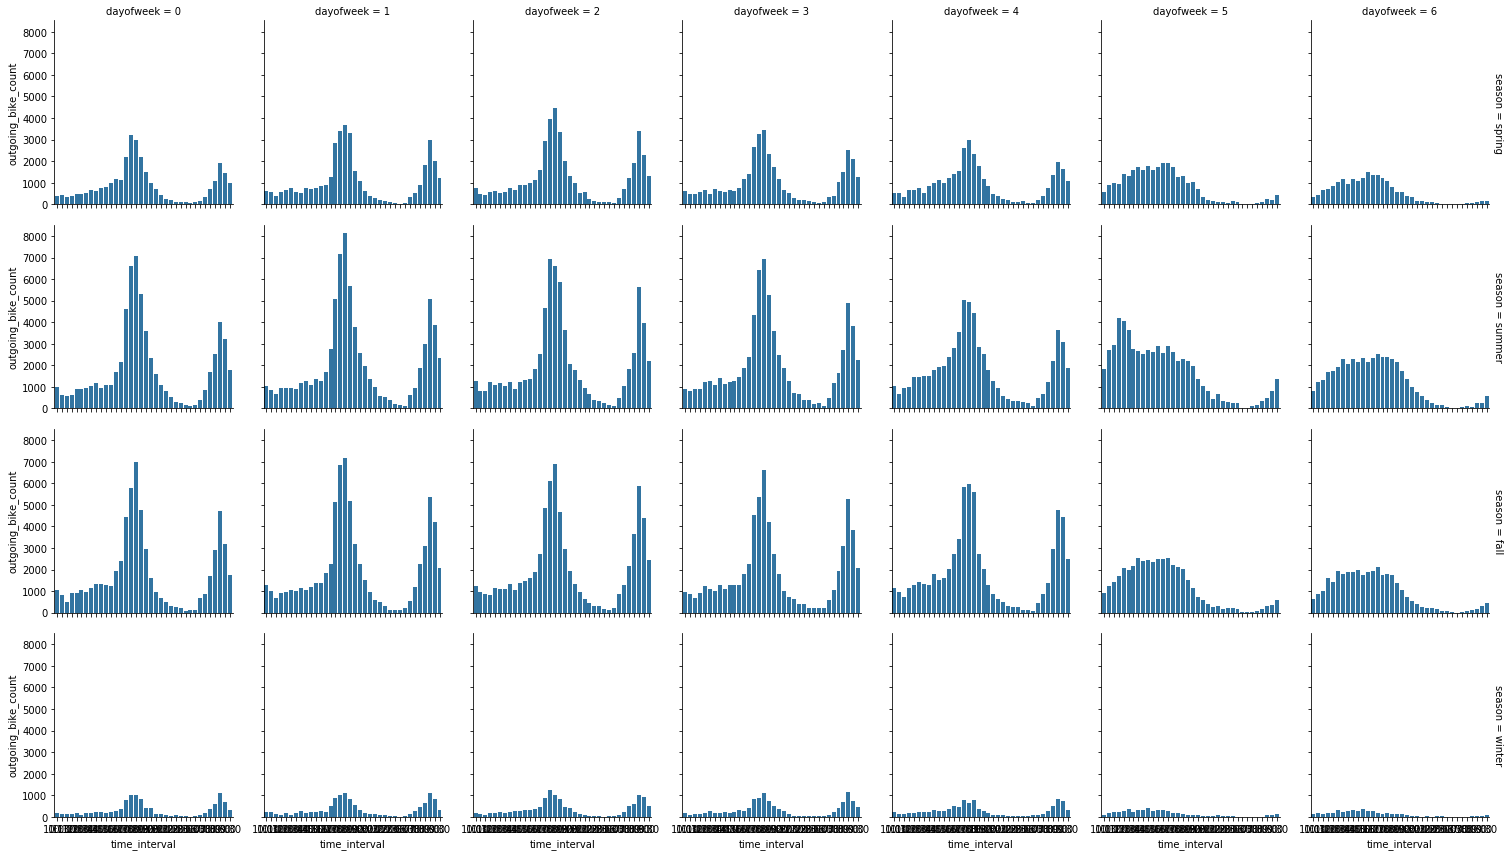

In [163]:
g=sns.FacetGrid(df.groupby(['time_interval','season','dayofweek']).sum()[['outgoing_bike_count']].reset_index(), row="season", col='dayofweek', margin_titles=True)
g.map(sns.barplot,'time_interval', "outgoing_bike_count")

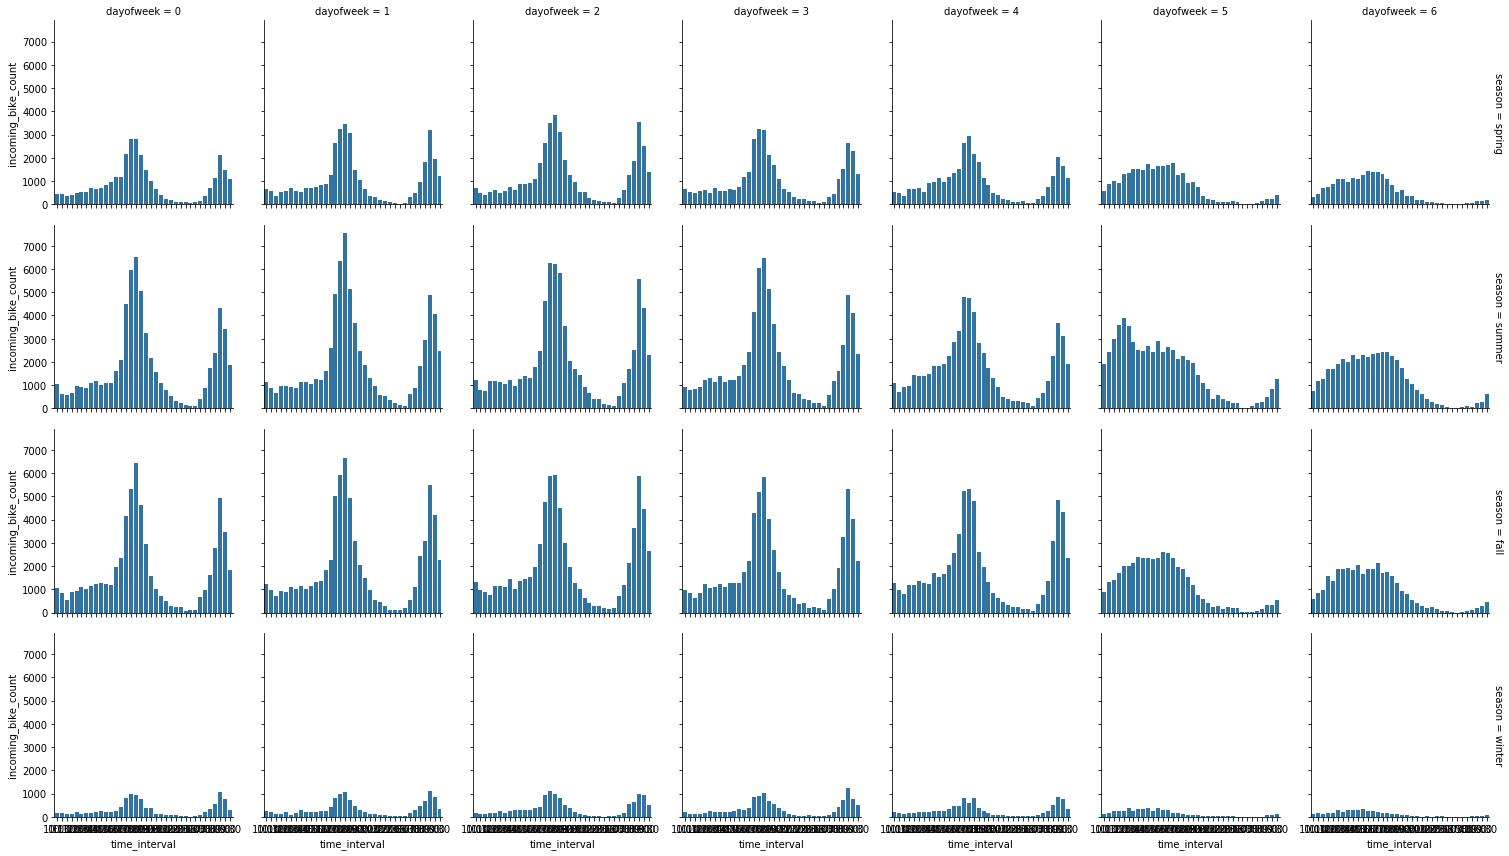

In [167]:
g=sns.FacetGrid(df.groupby(['time_interval','season','dayofweek']).sum()[['incoming_bike_count']].reset_index(), row="season", col='dayofweek', margin_titles=True)
g.map(sns.barplot,'time_interval', "incoming_bike_count")

### Categorize bike_demand (high, medium, low) and dock_demand (high, medium, low) for each station at each time_interval
Steps:
- 1. Calculate mean bike demand/dock demand from all bike stations given time_interval. 
- 2. Bike_demand is 'High' if the station's outgoing_bike_count is higher than averge, 'Medium' if the station's outgoing_bike_count is around the average, 'Low' if station's outgoing_bike_count is below average. 
- 3. Same goes for Dock Demand.

In [ ]:
df['bike_demand']
df['dock_demand']